# Introduction to Computer Vision: MNIST Challenge
Hi!

This is my first project on Kaggle and is done mainly for myself, I am sharing it as it might be useful for others. If you have any suggestions or remarks i would be glad to hear. 
Some sections were taken from cs231n homework, RSIP vision seminar (https://www.rsipvision.com/)  and various tutorials/kernels on-line.

#### Author: Shay Guterman, Hebrew University of Jerusalem: shaygu62@gmail.com


## Starting with Kaggle - imporing data 

Important: Switch settings to GPU

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf


# Input data files are available in the "../input/" directory.
import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


['test.csv', 'train.csv', 'sample_submission.csv']


## Importing the data the data

In [2]:
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# Import Data
train = pd.read_csv("../input/train.csv")
test= pd.read_csv("../input/test.csv")
print("Train size:{}\nTest size:{}".format(train.shape, test.shape))

# Transform Train and Test into images\labels.
x_train = train.drop(['label'], axis=1).values.astype('float32') # all pixel values
y_train = train['label'].values.astype('int32') # only labels i.e targets digits
x_test = test.values.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 28, 28) / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28) / 255.0

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(x_test.shape)

Train size:(42000, 785)
Test size:(28000, 784)
(37800, 28, 28)
(4200, 28, 28)
(37800,)
(28000, 28, 28)


## Visualize some examples from the dataset.
Showing some example per class

(37800, 28, 28)


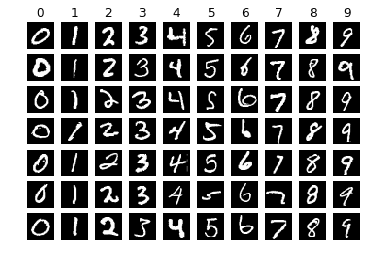

In [3]:
# classes for title
# num classes for amount of examples
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(x_train.shape)
num_classes = len(classes)
samples_per_class = 7
plt.figure(0)
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # plt.imshow(x_train[idx].astype('uint8'))
        plt.imshow(x_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Adding dimensions for keras

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)  
x_val = x_val.reshape(x_val.shape[0], 28, 28,1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28,1) 
print("Train size:{}\nvalidation size:{}\nTest size:{}".format(x_train.shape,x_val.shape, x_test.shape))

mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)


Train size:(37800, 28, 28, 1)
validation size:(4200, 28, 28, 1)
Test size:(28000, 28, 28, 1)


## Defining the architecture

### Option 1:
Light architecture with approximately 25K parameters. 
<br>Dropout for avoiding overfitting
<br>BatchNormalization for faster convergence time

In [9]:
from tensorflow.python.keras.layers import Input , Dense , Conv2D , Activation , Add,ReLU,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.python.keras.models import Model


input = Input(shape=[28, 28, 1])
x = Conv2D(16, (5, 5), strides=1, padding='same', name='conv1')(input)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform',name='batch1')(x)
x = Activation('relu', name='relu1')(x)
x = Dropout (0.5)(x)
x = Conv2D(16, (5, 5), strides=1, padding='same', name='conv2')(x)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform',name='batch2')(x)
x = Activation('relu', name='relu2')(x)
x = Dropout (0.5)(x)
x = Conv2D(32, (5, 5), strides=1, padding='same', name='conv2add')(x)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform',name='batch2add')(x)
x = Activation('relu', name='relu2add')(x)
x = Dropout (0.5)(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
x = Conv2D(32, (5, 5), strides=1, padding='same', name='conv3')(x)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform',name='batch3')(x)
x = Activation('relu', name='relu3')(x)
x = Dropout (0.5)(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = Conv2D(16, (5, 5), strides=1, padding='same', name='conv4')(x)
x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform',name='batch4')(x)
x = Activation('relu', name='relu4')(x)
x = Dropout (0.5)(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = Flatten()(x)
x = Dense(10, name='Dense10')(x)
x = Activation('softmax')(x)
model = Model(inputs = input, outputs =x)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 16)        416       
_________________________________________________________________
batch1 (BatchNormalizationV1 (None, 28, 28, 16)        64        
_________________________________________________________________
relu1 (Activation)           (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 16)        6416      
_________________________________________________________________
batch2 (BatchNormalizationV1 (None, 28, 28, 16)        64        
__________

### Defining a class to get access about information after each update

In [10]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

batch_stats = CollectBatchStats()

## Train the model using data augmentation

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.optimizers import Adam ,RMSprop

# # CREATE MORE IMAGES VIA DATA AUGMENTATION
# datagen = ImageDataGenerator(
#         rotation_range=10,  
#         zoom_range = 0.10,  
#         width_shift_range=0.1, 
#         height_shift_range=0.1)


optimizer = RMSprop(lr=0.001, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set a learning rate annealer
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.4, 
#                                             min_lr=0.0000001)

# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=2,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.02, # Randomly zoom image 
        width_shift_range=0.02,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.02,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically


datagen.fit(x_train)
batch_size = 64
epochs = 70

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/70
591/591 [==============================] - 18s 31ms/step - loss: 0.4704 - acc: 0.8898 - val_loss: 1.4723 - val_acc: 0.4026
Epoch 2/70
591/591 [==============================] - 16s 27ms/step - loss: 0.1130 - acc: 0.9647 - val_loss: 1.1309 - val_acc: 0.6436
Epoch 3/70
591/591 [==============================] - 16s 27ms/step - loss: 0.0897 - acc: 0.9725 - val_loss: 1.0268 - val_acc: 0.7564
Epoch 4/70
591/591 [==============================] - 16s 28ms/step - loss: 0.0785 - acc: 0.9760 - val_loss: 0.8038 - val_acc: 0.9429
Epoch 5/70
591/591 [==============================] - 16s 27ms/step - loss: 0.0667 - acc: 0.9791 - val_loss: 0.9586 - val_acc: 0.7657
Epoch 6/70
591/591 [==============================] - 16s 28ms/step - loss: 0.0610 - acc: 0.9815 - val_loss: 0.8367 - val_acc: 0.8645
Epoch 7/70
591/591 [==============================] - 16s 27ms/step - loss: 0.0599 - acc: 0.9813 - val_loss: 0.7313 - val_acc: 0.9443
Epoch 8/70
591/591 [==============================] - 16s 27ms

## Visualizations

In [ ]:
plt.figure(1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)


plt.figure(2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)


plt.figure(3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.figure(4)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()



## Plotting prediction
Stright forward taking some images and plotting predictions

In [ ]:
# predicted class
num_rows = 6
num_cols = 15
sample_size = num_rows * num_cols
indices = np.arange(sample_size)
x_pred = x_test[indices,:,:]
predictions = model.predict(x_pred)
x_pred = np.squeeze(x_test[indices,:,:])
y_pred = np.argmax(predictions,axis=1)

num_images = num_rows*num_cols
plt.figure(figsize=(num_cols*2, num_rows*2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i+1)
  plt.imshow(x_pred[i])
  plt.title(classes[y_pred[i]])
  # plt.subplot(num_rows, 2*num_cols, 2*i+2)
  # plot_value_array(i, predictions, test_labels)
plt.show()

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

y_vecs = model.predict(x_val)
y_pred = np.argmax(y_vecs, axis=1)
y_true = y_val
cm = confusion_matrix(y_true, y_pred)
# print(cm)

# plt.imshow(cm, cmap = 'ocean')
# plt.colorbar

min_val, max_val = 0, 15

# intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))
plt.figure(11)
fig, ax = plt.subplots()
ax.matshow(cm, cmap=plt.cm.Blues)
# ax.matshow(cm, cmap=plt.cm.magma_r)

for i in range(10):
    for j in range(10):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')


plt.xticks(range(10))
plt.yticks(range(10))
plt.title('Confusion matrix',size = 28)
plt.xlabel('True labeling',size = 20)
plt.ylabel('Predicted labeling',size = 20)
plt.rcParams.update({'font.size': 22})



## Miss-labeled data

In [ ]:
# Display some error results 
# y_vecs = model.predict(x_test)
# y_pred = np.argmax(y_vecs, axis=1)
Y_true = y_val
Y_pred_classes =  y_pred
Y_pred = y_vecs
X_val = x_val
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 4
    ncols = 4
    fig, ax = plt.subplots(nrows*2,ncols*2,sharex=True,sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=None, hspace=2)
    plt.figure(figsize=(num_cols*2, num_rows*2))

    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-25:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Submission

In [ ]:
# predict results
results = model.predict(x_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

## Save model

In [ ]:
# model.save('gdrive/My Drive/DL-ML/mnist/2203 995 percent.h5')

### Option 2:
Very Heavy architecture ~300k params per net with ensamble averaging over 15 nets
Taken Directly from: https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist

In [ ]:
# from tensorflow.python.keras.layers import Input , Dense , Conv2D , Activation , Add,ReLU,MaxPool2D,Flatten,Dropout,BatchNormalization
# from tensorflow.python.keras.models import Model
# from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

# nets = 15; 
# model = [0] *nets
# for j in range(nets):
#     input = Input(shape=[28, 28, 1])
#     x = Conv2D(16, (3, 3), strides=1, padding='same', name='conv1')(input)
#     x = Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1))(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(32, kernel_size = 3, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.4)(x)

#     x = Conv2D(64, kernel_size = 3, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(64, kernel_size = 3, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.4)(x)

#     x = Conv2D(128, kernel_size = 4, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Flatten()(x)
#     x = Dropout(0.4)(x)
#     x = Dense(10, activation='softmax')(x)
    
#     model[j] = Model(inputs = input, outputs =x)
#     # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
#     model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# #     print(model[j].summary())
    
# # DECREASE LEARNING RATE EACH EPOCH
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# # TRAIN NETWORKS
# history = [0] * nets
# epochs = 45
# y_binary = to_categorical(y_train)

# for j in range(nets):
#     X_train2, X_val2, Y_train2, Y_val2 = train_test_split(x_train, y_binary, test_size = 0.1)
#     history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
#         epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
#         validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
#     print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
#         j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

# # ENSEMBLE PREDICTIONS AND SUBMIT
# results = np.zeros( (X_test.shape[0],10) ) 
# for j in range(nets):
#     results = results + model[j].predict(X_test)
# results = np.argmax(results,axis = 1)
# results = pd.Series(results,name="Label")
# submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
# submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)